# Mixture of Experts: Multimodal Animal/Sound Recognition
This notebook demonstrates how to build a simple Mixture of Experts model that fuses text and image modalities for animal and sound classification. It leverages Keras, TensorFlow, and pre-trained embeddings.

In [1]:
# --- Imports ---

# Standard library imports
import io

# Third-party imports
import numpy as np
import requests
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Layer

## Vocabularies
Define fixed vocabularies for animals and sounds.

In [2]:
# Animal and sound vocabularies
sound_vocab = {"<pad>": 0, "cat": 1, "dog": 2, "meow": 3, "bark": 4}
inv_sound_vocab = {v: k for k, v in sound_vocab.items()}
animal_vocab = {"<pad>": 0, "cat": 1, "dog": 2}
inv_animal_vocab = {v: k for k, v in animal_vocab.items()}

## Dummy Constants
For missing modalities and baseline data.

In [3]:
dummy_text = "<empty>"
dummy_image = np.zeros((224,224,3), dtype=np.float32)

## Custom Layers: Text and Image Experts
Text uses Universal Sentence Encoder. <br> 
Image uses pre-trained MobileNetV2. <br>
Output is logits for sound (text) and animal (image).


In [4]:
class HubEmbeddingLayer(Layer):
    def __init__(self, hub_url="https://tfhub.dev/google/universal-sentence-encoder/4"):
        super().__init__()
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)
    def call(self, inputs):
        return self.hub_layer(inputs)

def build_text_expert():
    inp = Input(shape=(), dtype=tf.string)
    x = HubEmbeddingLayer()(inp)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(len(sound_vocab))(x)
    return Model(inp, out, name="TextExpert")

def build_image_expert():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False,
                                                   weights="imagenet", pooling="avg")
    base_model.trainable = False
    inp = Input(shape=(224,224,3))
    x = base_model(inp)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(len(animal_vocab))(x)
    return Model(inp, out, name="ImageExpert")


## Gating, Padding, and Softmax Utilities
Gates combine experts based on input presence, pads logits, and smooths outputs.

In [5]:
class GateLayer(Layer):
    def call(self, inputs):
        text_present, image_present = inputs  # shape (batch,1)
        gate_text = 1.0 - image_present  # text expert if no image
        gate_image = image_present       # image expert if image present
        gates = tf.concat([gate_text, gate_image], axis=1)
        return gates

def gating_entropy_loss(gate_weights):
    return -tf.reduce_mean(tf.reduce_sum(gate_weights * tf.math.log(gate_weights + 1e-10), axis=1))

class PadLayer(Layer):
    def __init__(self, pad_width):
        super().__init__()
        self.pad_width = pad_width
    def call(self, inputs):
        neg_inf = tf.fill([tf.shape(inputs)[0], self.pad_width], -1e9)
        return tf.concat([inputs, neg_inf], axis=1)

class SoftmaxWithTemp(Layer):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature
    def call(self, inputs):
        return tf.nn.softmax(inputs / self.temperature)

## Data Preparation
Loads small image and text sets. Combines for multimodal training.

In [6]:
def load_image_dataset(split="train[:80%]", num_images_per_class=10):
    # Load a specific slice of cats_vs_dogs dataset (default: first 80% for training)
    ds, info = tfds.load('cats_vs_dogs', split=split, with_info=True)
    cat_images, dog_images = [], []
    
    # Collect images up to desired numbers to keep balanced subsets
    for ex in ds.as_numpy_iterator():
        label = ex['label']  # 0=cat, 1=dog
        image = ex['image']
        image = tf.image.resize(image, (224,224)).numpy() / 255.0
        if label == 0 and len(cat_images) < num_images_per_class:
            cat_images.append(image)
        elif label == 1 and len(dog_images) < num_images_per_class:
            dog_images.append(image)
        if len(cat_images) >= num_images_per_class and len(dog_images) >= num_images_per_class:
            break

    images = np.concatenate([np.array(cat_images), np.array(dog_images)], axis=0)
    labels = np.array([animal_vocab['cat']] * num_images_per_class + [animal_vocab['dog']] * num_images_per_class, dtype=np.int32)
    text_inputs = np.array([dummy_text] * len(images))
    text_present = np.zeros((len(images),1), dtype=np.float32)
    image_present = np.ones((len(images),1), dtype=np.float32)
    return tf.data.Dataset.from_tensor_slices(((text_inputs, images, text_present, image_present), labels))


def load_text_dataset(is_validation=False):
    texts = ["cat", "dog", "cat", "dog", "cat", "dog", "cat", "dog"]
    sound_labels = np.array(
        [sound_vocab["meow"], sound_vocab["bark"], sound_vocab["meow"], sound_vocab["bark"],
         sound_vocab["meow"], sound_vocab["bark"], sound_vocab["meow"], sound_vocab["bark"]],
        dtype=np.int32)

    if is_validation:
        texts = texts[:2]
        sound_labels = sound_labels[:2]
    text_present = np.ones((len(texts),1), dtype=np.float32)
    image_present = np.zeros((len(texts),1), dtype=np.float32)
    dummy_images = np.zeros((len(texts), 224, 224, 3), dtype=np.float32)
    return tf.data.Dataset.from_tensor_slices(((texts, dummy_images, text_present, image_present), sound_labels))


def prepare_combined_dataset(split="train[:80%]"):
    # Prepare combined dataset with given split for images and full text
    image_ds = load_image_dataset(split=split, num_images_per_class=20)
    text_ds = load_text_dataset()
    combined = image_ds.concatenate(text_ds)
    combined = combined.shuffle(32).batch(4).prefetch(tf.data.AUTOTUNE)
    return combined


def prepare_combined_validation_dataset():
    # Prepare validation dataset from 80% to 90% slice, plus all text dataset
    image_ds = load_image_dataset(split="train[80%:90%]", num_images_per_class=4)
    text_ds = load_text_dataset()  # or separate smaller val text set if desired
    combined = image_ds.concatenate(text_ds)
    combined = combined.batch(4).prefetch(tf.data.AUTOTUNE)
    return combined

## Full Mixture of Experts Model
Combines text and image experts using gating, padding, and softmax normalization.<br>
Training supports multimodal loss and gating entropy regularization

In [7]:
class MoeModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.text_expert = build_text_expert()
        self.image_expert = build_image_expert()
        self.gate = GateLayer()
        self.pad_layer = PadLayer(len(sound_vocab) - len(animal_vocab))
        self.softmax_temp = SoftmaxWithTemp(0.7)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        self.lambda_image_aux = 0.8
        self.lambda_entropy = 0.01
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        self.val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    def call(self, inputs, training=False):
        text_input, image_input, text_present, image_present = inputs
        gate_weights = self.gate([text_present, image_present])
        text_logits = self.text_expert(text_input, training=training)
        image_logits = self.image_expert(image_input, training=training)
        image_logits_padded = self.pad_layer(image_logits)

        text_logits_norm = self.softmax_temp(text_logits)
        image_logits_norm = self.softmax_temp(image_logits_padded)

        combined_logits = gate_weights[:, 0:1] * text_logits_norm + gate_weights[:, 1:2] * image_logits_norm
        outputs = tf.nn.softmax(combined_logits)
        return outputs, gate_weights, text_logits, image_logits

    def train_step(self, data):
        (text_input, image_input, text_present, image_present), labels = data
        with tf.GradientTape() as tape:
            outputs, gate_weights, text_logits, image_logits = self((text_input, image_input, text_present, image_present), training=True)

            image_present_flat = tf.reshape(image_present, [-1])
            mask_image = tf.equal(image_present_flat, 1.0)
            mask_text = tf.logical_not(mask_image)

            text_labels = tf.boolean_mask(labels, mask_text)
            text_logits_masked = tf.boolean_mask(text_logits, mask_text)
            text_logits_masked = text_logits_masked[:, :len(sound_vocab)]

            image_labels = tf.boolean_mask(labels, mask_image)
            image_logits_masked = tf.boolean_mask(image_logits, mask_image)
            image_logits_masked = image_logits_masked[:, :len(animal_vocab)]

            text_loss = tf.cond(tf.greater(tf.size(text_labels), 0),
                                lambda: self.loss_fn(text_labels, text_logits_masked),
                                lambda: 0.0)

            image_loss = tf.cond(tf.greater(tf.size(image_labels), 0),
                                lambda: self.loss_fn(image_labels, image_logits_masked),
                                lambda: 0.0)

            entropy_loss = gating_entropy_loss(gate_weights)
            total_loss = text_loss + self.lambda_image_aux * image_loss + self.lambda_entropy * entropy_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.train_accuracy.update_state(labels, outputs)
        return {"loss": total_loss, "train_accuracy": self.train_accuracy.result()}

    def test_step(self, data):
        (text_input, image_input, text_present, image_present), labels = data
        outputs, _, _, _ = self((text_input, image_input, text_present, image_present), training=False)
        loss = self.loss_fn(labels, outputs)
        self.val_accuracy.update_state(labels, outputs)
        return {"loss": loss, "val_accuracy": self.val_accuracy.result()}

In [8]:
train_dataset = prepare_combined_dataset(split="train[:80%]")
val_dataset = prepare_combined_validation_dataset()

2025-09-03 16:59:17.930532: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [9]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_moe_model.keras", save_best_only=True, monitor="val_loss", mode="min"
)

moe_model = MoeModel()
moe_model.compile(optimizer=tf.keras.optimizers.Adam())

moe_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[checkpoint_cb]
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 1.9223 - train_accuracy: 0.5833 - val_loss: 1.5912 - val_val_accuracy: 0.6875
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 12.7519 - train_accuracy: 0.8542 - val_loss: 1.5543 - val_val_accuracy: 0.7500
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.6094 - train_accuracy: 0.8958 - val_loss: 1.5597 - val_val_accuracy: 0.7500
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.9073e-07 - train_accuracy: 0.9167 - val_loss: 1.5466 - val_val_accuracy: 1.0000
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.9024 - train_accuracy: 0.9167 - val_loss: 1.5350 - val_val_accuracy: 1.0000
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 13.0198 - train_accuracy: 0.9375 - val_loss: 1.5306 - val_val_accuracy: 1.0000
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.6094 - train_accuracy: 0.9792 - val_loss: 1.5323 - val_val_accuracy: 1.0000
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━

## Inference & Visualization
Provide utility for prediction with text/image inputs.

In [10]:
# load the best model
restored_model = MoeModel()
restored_model.compile(optimizer=tf.keras.optimizers.Adam())
restored_model.build(input_shape=[(None,), (None,224,224,3), (None,1), (None,1)])
restored_model.load_weights("best_moe_model.keras")

/Users/himaldwarakanath/Documents/hcl/python-training/tf_3.10_env/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'moe_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/himaldwarakanath/Documents/hcl/python-training/tf_3.10_env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
def load_image(url):
    response = requests.get(url)
    img = Image.open(io.BytesIO(response.content)).convert('RGB')
    img = img.resize((224,224))
    img_array = np.array(img) / 255.0
    return img_array

In [12]:
def predict_with_restored_model(text_input=None, image_input=None):
    if not text_input:
        text_input = dummy_text
    if image_input is None:
        image_input = dummy_image

    original_image = image_input.copy()

    # Ensure image shape and channels
    if image_input.ndim == 3 and image_input.shape[2] == 1:
        image_input = np.concatenate([image_input]*3, axis=2)
    if image_input.shape != (224, 224, 3):
        image_input = tf.image.resize(image_input, (224, 224)).numpy()

    # Prepare input batches
    text_batch = tf.constant([text_input])
    image_batch = np.expand_dims(image_input, axis=0)
    text_present = np.array([[0.0]], dtype=np.float32) if text_input == dummy_text else np.array([[1.0]], dtype=np.float32)
    image_present = np.array([[0.0]], dtype=np.float32) if np.all(image_input == 0) else np.array([[1.0]], dtype=np.float32)

    preds, gate_weights, _, _ = restored_model.predict([text_batch, image_batch, text_present, image_present], batch_size=1)

    gate_weights = np.squeeze(gate_weights)
    preds = np.squeeze(preds)

    pred_animal = None
    pred_sound = None

    if gate_weights[1] > gate_weights[0]:  # Image expert
        pred_id = np.argmax(preds[:len(animal_vocab)])
        pred_animal = inv_animal_vocab.get(pred_id, "unknown")
    else:  # Text expert
        pred_id = np.argmax(preds)
        pred_sound = inv_sound_vocab.get(pred_id, "unknown")

    if image_present[0,0] == 1.0:
        # Predict sound based on detected animal
        sound_text_batch = tf.constant([pred_animal if pred_animal else dummy_text])
        sound_image_batch = np.zeros((1,224,224,3), dtype=np.float32)
        sound_text_present = np.array([[1.0]], dtype=np.float32)
        sound_image_present = np.array([[0.0]], dtype=np.float32)

        sound_preds, _, _, _ = restored_model.predict([sound_text_batch, sound_image_batch, sound_text_present, sound_image_present], batch_size=1)
        sound_preds = np.squeeze(sound_preds)
        sound_pred_id = np.argmax(sound_preds)
        pred_sound = inv_sound_vocab.get(sound_pred_id, "unknown")

    print(f"Softmax output vector (image input): {preds}")
    print(f"Gate weights (image input): {gate_weights}")
    if pred_animal:
        print(f"Predicted animal: {pred_animal}")
    if pred_sound:
        print(f"Predicted sound for '{pred_animal or text_input}': {pred_sound}")

    # Show original image
    display(Image.fromarray(np.uint8(original_image * 255)))
    print("-" * 50)

    return pred_animal, pred_sound

## Example Use
Test with custom images and/or text.

Test: text input 'dog'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Softmax output vector (image input): [0.18268321 0.1884623  0.18243672 0.18498452 0.2614333 ]
Gate weights (image input): [1. 0.]
Predicted sound for 'dog': bark


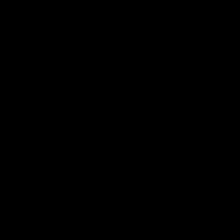

--------------------------------------------------
Test: text input 'canine'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Softmax output vector (image input): [0.18848169 0.1938166  0.18833241 0.19124538 0.23812385]
Gate weights (image input): [1. 0.]
Predicted sound for 'canine': bark


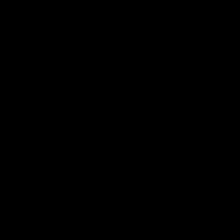

--------------------------------------------------
Test: text input 'wolf'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Softmax output vector (image input): [0.19623856 0.19217749 0.19235033 0.2091006  0.21013303]
Gate weights (image input): [1. 0.]
Predicted sound for 'wolf': bark


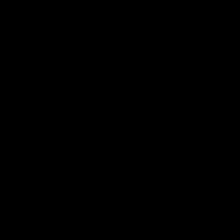

--------------------------------------------------
Test: text input 'cat'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Softmax output vector (image input): [0.19215523 0.17540035 0.18018405 0.26945758 0.18280283]
Gate weights (image input): [1. 0.]
Predicted sound for 'cat': meow


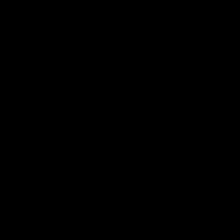

--------------------------------------------------
Test: text input 'feline'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Softmax output vector (image input): [0.19735941 0.18339324 0.18660891 0.2411708  0.19146767]
Gate weights (image input): [1. 0.]
Predicted sound for 'feline': meow


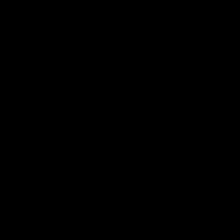

--------------------------------------------------
Test: text input 'tiger'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Softmax output vector (image input): [0.19856088 0.18959002 0.19104232 0.22205953 0.19874725]
Gate weights (image input): [1. 0.]
Predicted sound for 'tiger': meow


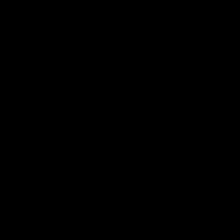

--------------------------------------------------
Test: text input 'puma'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Softmax output vector (image input): [0.19783151 0.1935042  0.19389726 0.21260454 0.20216247]
Gate weights (image input): [1. 0.]
Predicted sound for 'puma': meow


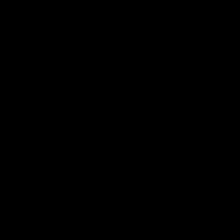

--------------------------------------------------
Test: image input
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Softmax output vector (image input): [0.15213014 0.39934734 0.14951497 0.14950377 0.14950377]
Gate weights (image input): [0. 1.]
Predicted animal: cat
Predicted sound for 'cat': meow


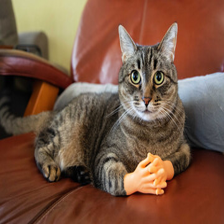

--------------------------------------------------
Test: image input
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Softmax output vector (image input): [0.14920412 0.14960352 0.40312228 0.14903502 0.14903502]
Gate weights (image input): [0. 1.]
Predicted animal: dog
Predicted sound for 'dog': bark


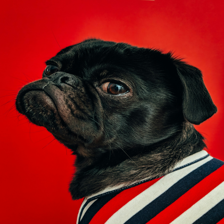

--------------------------------------------------
Test: text 'cat' and image 'cat'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Softmax output vector (image input): [0.15213014 0.39934734 0.14951497 0.14950377 0.14950377]
Gate weights (image input): [0. 1.]
Predicted animal: cat
Predicted sound for 'cat': meow


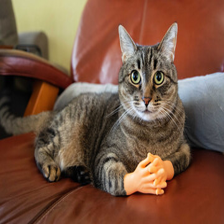

--------------------------------------------------
Test: text 'cat' and image 'dog'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Softmax output vector (image input): [0.14920412 0.14960352 0.40312228 0.14903502 0.14903502]
Gate weights (image input): [0. 1.]
Predicted animal: dog
Predicted sound for 'dog': bark


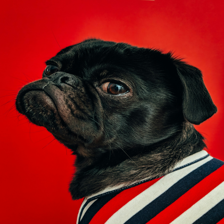

--------------------------------------------------
Test: text 'dog' and image 'dog'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Softmax output vector (image input): [0.14920412 0.14960352 0.40312228 0.14903502 0.14903502]
Gate weights (image input): [0. 1.]
Predicted animal: dog
Predicted sound for 'dog': bark


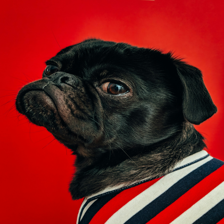

--------------------------------------------------
Test: text 'dog' and image 'cat'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Softmax output vector (image input): [0.15213014 0.39934734 0.14951497 0.14950377 0.14950377]
Gate weights (image input): [0. 1.]
Predicted animal: cat
Predicted sound for 'cat': meow


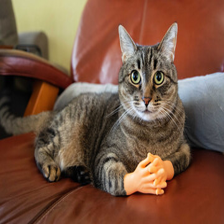

--------------------------------------------------
Test: text 'random string' and image 'cat'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Softmax output vector (image input): [0.15213014 0.39934734 0.14951497 0.14950377 0.14950377]
Gate weights (image input): [0. 1.]
Predicted animal: cat
Predicted sound for 'cat': meow


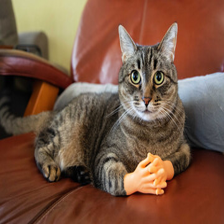

--------------------------------------------------
Test: text 'random string' and image 'dog'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Softmax output vector (image input): [0.14920412 0.14960352 0.40312228 0.14903502 0.14903502]
Gate weights (image input): [0. 1.]
Predicted animal: dog
Predicted sound for 'dog': bark


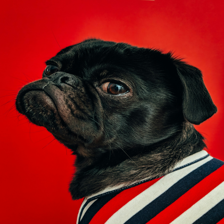

--------------------------------------------------
Test: text 'random string' and image 'hyena'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Softmax output vector (image input): [0.15024006 0.14923175 0.4022365  0.1491459  0.1491459 ]
Gate weights (image input): [0. 1.]
Predicted animal: dog
Predicted sound for 'dog': bark


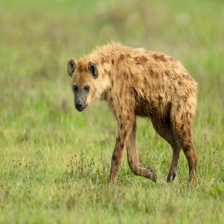

--------------------------------------------------
Test: text 'random string' and image 'lion'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Softmax output vector (image input): [0.15128507 0.1505985  0.3990249  0.14954574 0.14954574]
Gate weights (image input): [0. 1.]
Predicted animal: dog
Predicted sound for 'dog': bark


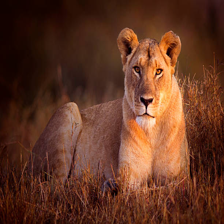

--------------------------------------------------
Test: text 'random string' and image 'ragdoll'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Softmax output vector (image input): [0.14896646 0.40441737 0.14887236 0.14887185 0.14887185]
Gate weights (image input): [0. 1.]
Predicted animal: cat
Predicted sound for 'cat': meow


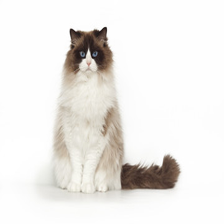

--------------------------------------------------


In [13]:
cat_img_url = "https://t3.ftcdn.net/jpg/04/73/67/64/240_F_473676400_VyH1ey15WGBA6L9MILjha6thtMVfuRh2.jpg"
dog_img_url = "https://images.unsplash.com/photo-1517423440428-a5a00ad493e8"
hyena_img_url = "https://media.istockphoto.com/id/1391602527/photo/hyena-on-the-open-savannah.jpg?s=612x612&w=0&k=20&c=EEfVDDBKSwQE-z9hYJCmoCP1HrdRH4gDQzXN6Rs4iIw="
lion_img_url = "https://media.istockphoto.com/id/598786236/photo/lioness.jpg?s=612x612&w=0&k=20&c=mBhmCMds9rTSRBaxIORZZJ5JHC9p9YlPAsBBJ6OD3nQ="
ragdoll_img_url = "https://t4.ftcdn.net/jpg/01/93/24/29/240_F_193242946_iZa3W8RVhr66F8r89KinSFsNjmHnsiLR.jpg"


# Example Tests

# text-only
text_only_inputs = ["dog", "canine", "wolf", "cat", "feline", "tiger", "puma"]
for text_input in text_only_inputs:
    print("\033[1m" + f"Test: text input '{text_input}'" + "\033[0m")
    predict_with_restored_model(text_input=text_input)

# image-only
image_only_inputs = [load_image(cat_img_url), load_image(dog_img_url)]
for image_input in image_only_inputs:
    print("\033[1m" +  f"Test: image input" + "\033[0m")
    predict_with_restored_model(image_input=image_input)

# text and image (text input is ignored by the model in this implementation)
text_and_image_inputs = [("cat", load_image(cat_img_url), "cat"), 
                         ("cat", load_image(dog_img_url), "dog"),
                         ("dog", load_image(dog_img_url), "dog"),
                         ("dog", load_image(cat_img_url), "cat"),
                         ("random string", load_image(cat_img_url), "cat"),
                         ("random string", load_image(dog_img_url), "dog"),
                         ("random string", load_image(hyena_img_url), "hyena"),
                         ("random string", load_image(lion_img_url), "lion"),
                         ("random string", load_image(ragdoll_img_url), "ragdoll")]

for text_input, image_input, image_desc in text_and_image_inputs:
    print("\033[1m" + f"Test: text '{text_input}' and image '{image_desc}'" + "\033[0m")
    predict_with_restored_model(text_input=text_input, image_input=image_input)
